In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [21]:
imagedir = os.listdir("/kaggle/input/new-idd-dataset/IDD_RESIZED/image_archive/")
maskdir = os.listdir("/kaggle/input/new-idd-dataset/IDD_RESIZED/mask_archive/")

imagedir.sort()
maskdir.sort()

In [4]:
image_paths = []
for name in tqdm(imagedir):
    image_paths.append(IMG_DIR + name)
    
mask_paths = []
for name in tqdm(maskdir):
    mask_paths.append(MASK_DIR + name)

100%|██████████| 6993/6993 [00:00<00:00, 1650392.07it/s]


In [5]:
train_image_paths = image_paths[:int(len(image_paths)*0.85)]
train_mask_paths = mask_paths[:int(len(image_paths)*0.85)]

val_image_paths = image_paths[int(len(image_paths)*0.85):]
val_mask_paths = mask_paths[int(len(image_paths)*0.85):]

In [6]:
def random_flip(image, mask):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
    return image, mask

def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)

    image = tf.image.resize(image, (256, 256))
    mask = tf.image.resize(mask, (256, 256))

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32)

    return image, mask

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_mask_paths))

train_dataset = train_dataset.map(load_image_and_mask)
val_dataset = val_dataset.map(load_image_and_mask)

augmented_dataset1 = train_dataset.map(random_flip)
train_dataset = train_dataset.concatenate(augmented_dataset1)

batch_size = 32
buffer_size = 500
train_dataset = train_dataset.shuffle(buffer_size)

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset, val_dataset, len(train_dataset)

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>,
 372)

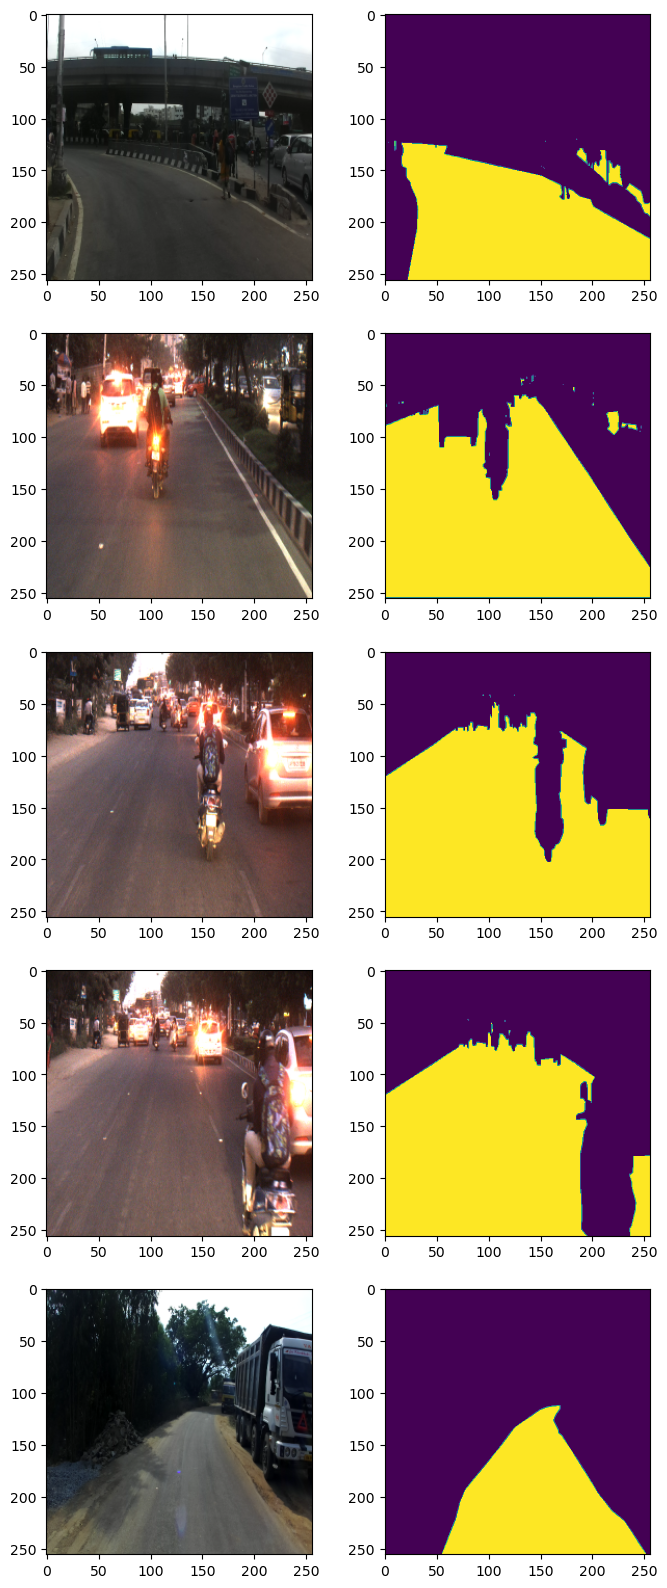

In [8]:
images, masks = next(iter(train_dataset))
fig, ax = plt.subplots(5,2, figsize = (8, 20))
for i in range(5):
    ax[i][0].imshow(images[i])
    ax[i][1].imshow(masks[i])

In [9]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.clip_by_value(y_true + y_pred, 0, 1))
    iou = intersection / union
    
    return iou

In [10]:
def create_deeplabv3plus(input_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
    last_conv_layer = base_model.get_layer('block13_sepconv2_bn')

    x = last_conv_layer.output
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    x = tf.keras.layers.UpSampling2D(size = (4, 4), interpolation = 'bilinear')(x)
    x = tf.keras.layers.UpSampling2D(size = (4, 4), interpolation = 'bilinear')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

input_shape = (256, 256, 3)
model = create_deeplabv3plus(input_shape)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', iou_metric])
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [11]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/deeplabv3_small_256x256.h5', verbose=1, save_best_only=True)

deeplabv3_results = model.fit(train_dataset,
                    validation_data = val_dataset,
                    validation_freq = 1,
                    epochs = 10,
                    verbose=1,
                    callbacks=checkpointer
                   )

Epoch 1/10


2025-05-14 09:44:47.912689: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


372/372 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9559 - iou_metric: 0.8587
Epoch 1: val_loss improved from inf to 0.13251, saving model to /kaggle/working/deeplabv3_small_256x256.h5
372/372 [==============================] - 310s 715ms/step - loss: 0.1067 - accuracy: 0.9559 - iou_metric: 0.8587 - val_loss: 0.1325 - val_accuracy: 0.9518 - val_iou_metric: 0.8396
Epoch 2/10
372/372 [==============================] - ETA: 0s - loss: 0.0815 - accuracy: 0.9656 - iou_metric: 0.8875
Epoch 2: val_loss improved from 0.13251 to 0.12504, saving model to /kaggle/working/deeplabv3_small_256x256.h5
372/372 [==============================] - 269s 718ms/step - loss: 0.0815 - accuracy: 0.9656 - iou_metric: 0.8875 - val_loss: 0.1250 - val_accuracy: 0.9535 - val_iou_metric: 0.8443
Epoch 3/10
372/372 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9680 - iou_metric: 0.8958
Epoch 3: val_loss did not improve from 0.12504
372/372 [========================

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


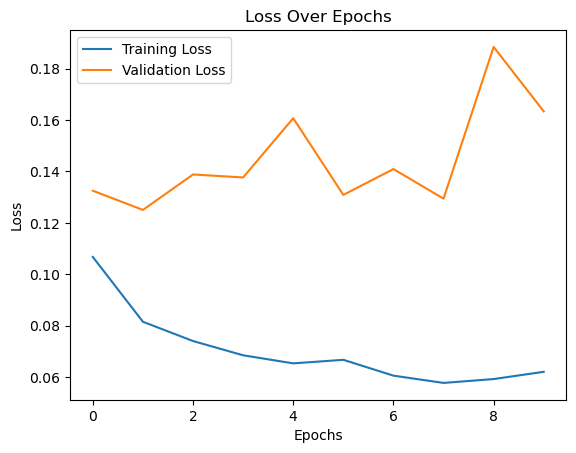

In [12]:
import matplotlib.pyplot as plt

plt.plot(deeplabv3_results.history['loss'], label='Training Loss')
plt.plot(deeplabv3_results.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [14]:
import os

save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)

model.save_weights(os.path.join(save_dir, "deeplabv3_weights.h5"))

print(f"Model weights saved in: {save_dir}/deeplabv3_weights.h5")

Model weights saved in: /kaggle/working/models/deeplabv3_weights.h5


In [15]:
campus_dir = os.listdir("/kaggle/input/road-images/ROAD")
campus_images_names = [ names for names in campus_dir if names.endswith(".jpeg")]
images = []
preds = []
for i in tqdm(range(0,len(campus_images_names))):
    image = tf.io.read_file("/kaggle/input/road-images/ROAD/" + campus_images_names[i])
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    images.append(image)
    mask = model.predict(tf.expand_dims(image, axis=0), verbose = 0)[0]
    preds.append(mask)
    
images = np.array(images)
preds = np.array(preds)

100%|██████████| 31/31 [00:04<00:00,  7.14it/s]


In [16]:
pred2 = preds.copy()
for i in tqdm(range(0, len(pred2))):
    for j in range(0,len(pred2[i])):
        for k in range(0,len(pred2[i][j])):
            if pred2[i][j][k] > 0.8 :
                pred2[i][j][k] = 255
            else:
                pred2[i][j][k] = 0

100%|██████████| 31/31 [00:05<00:00,  6.12it/s]


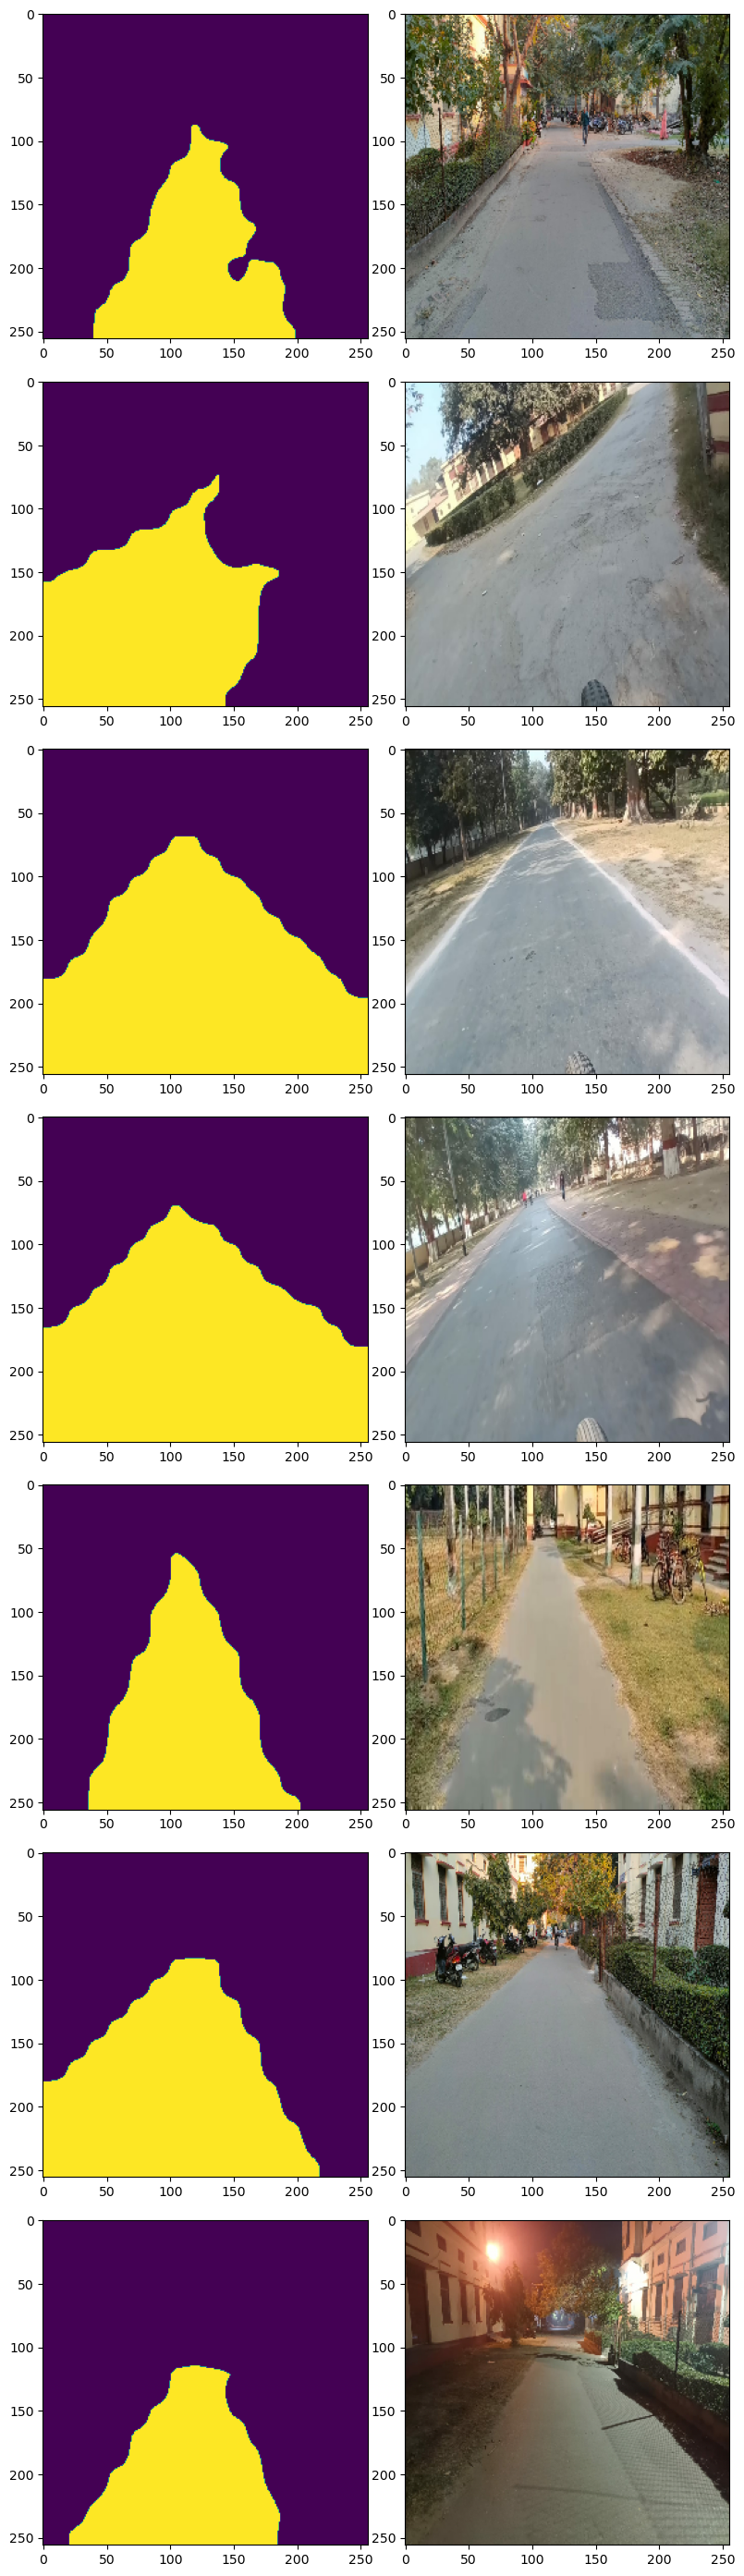

In [20]:
fig, ax = plt.subplots(7, 2, figsize=(8, 28))

for idx, image_idx in enumerate(range(4, 11)):
    ax[idx][0].imshow(pred2[image_idx])
    ax[idx][1].imshow(images[image_idx])

plt.tight_layout()
plt.show()